<a href="https://colab.research.google.com/github/j-a-r-v-i/Analyzing-the-bitcoin-trends/blob/master/topic_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import datetime

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

import zipfile
from google.colab import files
uploaded = files.upload()

Saving sample_submission_UVKGLZE.csv to sample_submission_UVKGLZE.csv
Saving test.csv to test.csv


In [4]:
import io
df_test= pd.read_csv(io.BytesIO(uploaded['test.csv']))
df_submit = pd.read_csv(io.BytesIO(uploaded['sample_submission_UVKGLZE.csv']))
df_train = pd.read_csv(io.BytesIO(uploaded['train.csv']))

In [5]:
df_train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [6]:
df_test.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [7]:
df_train.shape

(20972, 9)

In [8]:

print('number of titles:', df_train['TITLE'].nunique())

number of titles: 20972


In [10]:
df_train.isna().sum()

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

# Topic Modelling

In [11]:

#Installing the libraries
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.9MB/s 
     |████████████████████████████████| 552kB 16.6MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=7c8d136a7c3b5bac371e49ef30043a808a02b81e2b1ac43186f32e4804dba1f0
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=70ff8f5af63862a27d8b9992c8f8ab084916ae4af60b4521126cf92c04cd141b
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [12]:

!pip install gensim --upgrade

     |████████████████████████████████| 24.2MB 168kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [13]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2020-08-20 07:08:57--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  12.4MB/s    in 1.2s    

2020-08-20 07:08:58 (12.4 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [16]:
import os

In [17]:
df=df_train

In [18]:

df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [19]:

os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [20]:
#Topic modeling
# spacy for lemmatization
import spacy;
import en_core_web_sm
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [21]:
#text preprocessing
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
nltk.download('wordnet')

#hide warning
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
df.columns

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')

In [ ]:

# tokenize each sentence into a list of words, removing punctuations
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['ABSTRACT']))

# Remove Stop and common Words
stopwords = nltk.corpus.stopwords.words('english')
# 'home', 'stay','new','york', 'time',
newStopWords =  ['s','t',  'm', 're','don','ve','2', '3', '1', 
                 'it', 'i', 'us', 'get', 'you', 'let', 'going', 'know', 
                'make', 'take', 'still','got', 'can', 'this', 'all', 'me','go',
                'even', 'here', 'well', 'much', 'many', 'way', 'want', 'every', 'little']
stopwords.extend(newStopWords)

data_words = [[word for word in doc if word not in stopwords] for doc in data_words]

In [ ]:
# restrict words to only noun, adjective, verb and adverb
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

## Finding the optimal number of topics using LdaMallet model

In [ ]:
start=24
limit=35
step=2
random = 155

In [ ]:
# Write the function to compute coherence values for each model. 
# This could help us choose how many topics should be included into our model.

def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word,random_seed=random)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# compute coherence values for each model

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

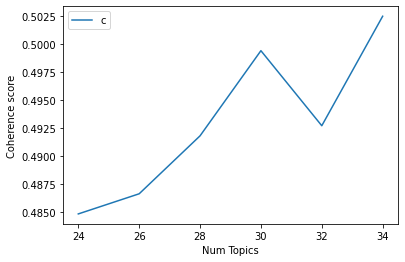

In [ ]:
# plot the coherence values when number of topics equals to different numbers
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
# The graph tell us about what number of topics to choose so we will choose 28 as it has maximum coherence score at that point

In [ ]:

# plot the coherence values when number of topics equals to different numbers
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

#If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.
#So for further steps I will choose the model with 30 topics itself.

Num Topics = 24  has Coherence Value of 0.4848
Num Topics = 26  has Coherence Value of 0.4866
Num Topics = 28  has Coherence Value of 0.4918
Num Topics = 30  has Coherence Value of 0.4994
Num Topics = 32  has Coherence Value of 0.4927
Num Topics = 34  has Coherence Value of 0.5025


## Finding Key Words for each topic using optimal LdaMallet model¶

In [ ]:
#mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus,
                                             num_topics=30, 
                                             id2word=id2word,
                                             random_seed = 155)

In [ ]:
model_topics = ldamallet.show_topics(formatted=False)

pprint(sorted(ldamallet.print_topics(num_words=4)))

[(1, '0.045*"phase" + 0.040*"state" + 0.032*"field" + 0.028*"magnetic"'),
 (3, '0.020*"star" + 0.017*"observation" + 0.016*"find" + 0.014*"mass"'),
 (4, '0.171*"time" + 0.023*"long" + 0.022*"memory" + 0.020*"short"'),
 (5, '0.064*"image" + 0.031*"object" + 0.022*"base" + 0.021*"method"'),
 (7, '0.027*"language" + 0.022*"base" + 0.021*"program" + 0.019*"search"'),
 (8, '0.032*"flow" + 0.026*"particle" + 0.024*"simulation" + 0.019*"wave"'),
 (11, '0.108*"system" + 0.048*"control" + 0.025*"environment" + 0.024*"agent"'),
 (12, '0.080*"set" + 0.060*"class" + 0.048*"space" + 0.044*"show"'),
 (14, '0.095*"structure" + 0.074*"property" + 0.050*"type" + 0.047*"local"'),
 (17,
  '0.026*"study" + 0.025*"behavior" + 0.020*"process" + 0.018*"individual"'),
 (18, '0.081*"learn" + 0.049*"task" + 0.047*"learning" + 0.044*"feature"'),
 (19,
  '0.020*"material" + 0.018*"energy" + 0.018*"frequency" + 0.014*"optical"'),
 (20, '0.053*"graph" + 0.040*"number" + 0.035*"bound" + 0.030*"give"'),
 (22,
  '0.03

In [ ]:
pprint(model_topics)

[(19,
  [('material', 0.02049927113702624),
   ('energy', 0.018458454810495628),
   ('frequency', 0.01754737609329446),
   ('optical', 0.013720845481049562),
   ('electron', 0.012408892128279883),
   ('surface', 0.012135568513119534),
   ('light', 0.01173469387755102),
   ('high', 0.011516034985422741),
   ('temperature', 0.010823615160349855),
   ('mode', 0.010787172011661808)]),
 (27,
  [('user', 0.03731228636171602),
   ('information', 0.019069017167876484),
   ('social', 0.018320082958866227),
   ('community', 0.017436724661059264),
   ('research', 0.011483657871490572),
   ('online', 0.010907554633790376),
   ('content', 0.010888351192533702),
   ('paper', 0.010465875484886892),
   ('topic', 0.009428889657026538),
   ('identify', 0.008622345124246264)]),
 (29,
  [('component', 0.03243206947490935),
   ('discuss', 0.030708626169479385),
   ('result', 0.030641479027709386),
   ('theory', 0.02755271050628945),
   ('work', 0.02744079860333945),
   ('present', 0.02699315099153946),
   

In [ ]:

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)
#More the coherence score more is better keyword


Coherence Score:  0.49942029521406395


## Dominant topic for each document

In [ ]:
tm_results = ldamallet[corpus]

In [ ]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

In [ ]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]

In [ ]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
Term1,model,phase,distribution,star,time,image,sequence,language,flow,method,prediction,system,set,problem,structure,large,group,study,learn,material,graph,power,application,point,network,function,high,user,datum,component
Term2,process,state,sample,observation,long,object,pattern,base,particle,function,study,control,class,algorithm,property,scale,give,behavior,task,energy,number,performance,design,dimensional,neural,equation,source,information,method,discuss
Term3,parameter,field,estimate,find,memory,base,complex,program,simulation,gradient,effect,environment,space,optimization,type,number,prove,process,learning,frequency,bound,propose,system,case,deep,solution,signal,social,propose,result
Term4,inference,magnetic,random,mass,short,method,cell,search,wave,matrix,base,agent,show,solve,local,small,theory,individual,feature,optical,give,scheme,provide,dimension,train,condition,present,community,base,theory
Term5,variable,spin,probability,line,temporal,propose,mechanism,text,force,stochastic,predict,state,give,optimal,study,size,invariant,game,machine,electron,bind,rate,tool,space,training,operator,measurement,research,approach,work


In [ ]:
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,Terms per Topic
Topic1,"model, process, parameter, inference, variable, prior, uncertainty, approach, latent, probabilistic, base, variational, bayesian, chain, markov, modeling, include, information, framework, posterior"
Topic2,"phase, state, field, magnetic, spin, transition, temperature, interaction, system, quantum, order, lattice, topological, symmetry, strong, couple, critical, coupling, gap, energy"
Topic3,"distribution, sample, estimate, random, probability, estimator, estimation, parameter, statistical, error, procedure, statistic, sampling, assumption, regression, variable, asymptotic, rate, density, bias"
Topic4,"star, observation, find, mass, line, formation, galaxy, planet, observe, gas, stellar, region, emission, disk, density, dark, survey, low, solar, orbit"
Topic5,"time, long, memory, short, temporal, event, step, change, fast, computation, compute, require, efficient, term, parallel, show, state, speed, present, run"
Topic6,"image, object, base, method, propose, detection, approach, feature, filter, visual, map, end, shape, recognition, reconstruction, quality, generate, challenge, speech, video"
Topic7,"sequence, pattern, complex, cell, mechanism, interaction, growth, show, protein, system, activity, brain, single, specific, biological, understand, dynamic, represent, identify, find"
Topic8,"language, base, program, search, text, word, paper, rule, semantic, system, query, present, generate, approach, natural, logic, work, tool, technique, code"
Topic9,"flow, particle, simulation, wave, force, dynamic, regime, body, field, energy, velocity, pressure, numerical, fluid, motion, initial, law, instability, effect, transport"
Topic10,"method, function, gradient, matrix, stochastic, convergence, noise, linear, low, error, sparse, rate, rank, show, vector, norm, result, paper, decomposition, tensor"


In [ ]:
# create a dataframe
corpus_topic_df = pd.DataFrame()
# get the Titles from the original dataframe
corpus_topic_df['TITLE'] = df.TITLE
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df.head()

,TITLE,Dominant Topic,Contribution %,Topic Terms
0,Reconstructing Subject-Specific Effect Maps,11,18.93,"prediction, study, effect, base, predict, result, comparison, identify, test, analysis, compare, difference, approach, level, subject, provide, treatment, apply, high, standard"
1,Rotation Invariance Neural Network,6,9.66,"image, object, base, method, propose, detection, approach, feature, filter, visual, map, end, shape, recognition, reconstruction, quality, generate, challenge, speech, video"
2,Spherical polyharmonics and Poisson kernels for polyharmonic functions,26,9.93,"function, equation, solution, condition, operator, order, nonlinear, obtain, derive, differential, discrete, continuous, term, stability, coefficient, form, linear, numerical, case, partial"
3,A finite element approximation for the stochastic Maxwell--Landau--Lifshitz--Gilbert system,26,17.58,"function, equation, solution, condition, operator, order, nonlinear, obtain, derive, differential, discrete, continuous, term, stability, coefficient, form, linear, numerical, case, partial"
4,Comparative study of Discrete Wavelet Transforms and Wavelet Tensor Train decomposition to feature extraction of FTIR data of medicinal plants,19,12.98,"learn, task, learning, feature, machine, dataset, classification, representation, performance, label, domain, propose, training, classifier, approach, method, knowledge, art, prediction, transfer"


In [ ]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=df["TITLE"]):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num+1), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = sent_topics_df.join(contents)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=df["TITLE"])
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'TITLE']

# Show

In [ ]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,TITLE
0,0,11.0,0.1893,"prediction, study, effect, base, predict, result, comparison, identify, test, analysis",Reconstructing Subject-Specific Effect Maps
1,1,6.0,0.0966,"image, object, base, method, propose, detection, approach, feature, filter, visual",Rotation Invariance Neural Network
2,2,26.0,0.0993,"function, equation, solution, condition, operator, order, nonlinear, obtain, derive, differential",Spherical polyharmonics and Poisson kernels for polyharmonic functions
3,3,26.0,0.1758,"function, equation, solution, condition, operator, order, nonlinear, obtain, derive, differential",A finite element approximation for the stochastic Maxwell--Landau--Lifshitz--Gilbert system
4,4,19.0,0.1298,"learn, task, learning, feature, machine, dataset, classification, representation, performance, label",Comparative study of Discrete Wavelet Transforms and Wavelet Tensor Train decomposition to feature extraction of FTIR data of medicinal plants


In [ ]:
df_merged= pd.merge(df,df_dominant_topic, on=["TITLE"])

In [ ]:
df_merged.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,1,Reconstructing Subject-Specific Effect Maps,"Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each individual\nmeasurement extracted from the subject's data. While global inference is widely\nused, local inference, which can be used to form subject-specific effect maps,\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands. In this article, we propose a reconstruction\nmethod, named RSM, to improve subject-specific detections of predictive\nmodeling approaches and in particular, binary classifiers. RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers. The proposed method is a wrapper-type\nalgorithm that can be used with different binary classifiers in a diagnostic\nmanner, i.e. without information on condition presence. Reconstruction is posed\nas a Maximum-A-Posteriori problem with a prior model whose parameters are\nestimated from training data in a classifier-specific fashion. Experimental\nevaluation is performed on synthetically generated data and data from the\nAlzheimer's Disease Neuroimaging Initiative (ADNI) database. Results on\nsynthetic data demonstrate that using RSM yields higher detection accuracy\ncompared to using models directly or with bootstrap averaging. Analyses on the\nADNI dataset show that RSM can also improve correlation between\nsubject-specific detections in cortical thickness data and non-imaging markers\nof Alzheimer's Disease (AD), such as the Mini Mental State Examination Score\nand Cerebrospinal Fluid amyloid-$\beta$ levels. Further reliability studies on\nthe longitudinal ADNI dataset show improvement on detection reliability when\nRSM is used.\n",1,0,0,0,0,0,0,11.0,0.1893,"prediction, study, effect, base, predict, result, comparison, identify, test, analysis"
1,2,Rotation Invariance Neural Network,"Rotation invariance and translation invariance have great values in image\nrecognition tasks. In this paper, we bring a new architecture in convolutional\nneural network (CNN) named cyclic convolutional layer to achieve rotation\ninvariance in 2-D symbol recognition. We can also get the position and\norientation of the 2-D symbol by the network to achieve detection purpose for\nmultiple non-overlap target. Last but not least, this architecture can achieve\none-shot learning in some cases using those invariance.\n",1,0,0,0,0,0,1,6.0,0.0966,"image, object, base, method, propose, detection, approach, feature, filter, visual"
2,3,Spherical polyharmonics and Poisson kernels for polyharmonic functions,"We introduce and develop the notion of spherical polyharmonics, which are a\nnatural generalisation of spherical harmonics. In particular we study the\ntheory of zonal polyharmonics, which allows us, analogously to zonal harmonics,\nto construct Poisson kernels for polyharmonic functions on the union of rotated\nballs. We find the representation of Poisson kernels and zonal polyharmonics in\nterms of the Gegenbauer polynomials. We show the connection between the\nclassical Poisson kernel for harmonic functions on the ball, Poisson kernels\nfor polyharmonic functions on the union of rotated balls, and the Cauchy-Hua\nkernel for holomorphic functions on the Lie ball.\n",0,0,1,0,0,0,2,26.0,0.0993,"function, equation, solution, condition, operator, order, nonlinear, obtain, derive, differential"
3,4,A finite element approximation for the stochastic Maxwell--Landau--Lifshitz--Gilbert system,"The stochastic Landau--Lifshitz--Gilbert (LLG) equation coupled with the\nMaxwell equati

In [ ]:
df_merged.columns

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance',
       'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords'],
      dtype='object')

In [ ]:
df_merged=df_merged.drop(['Dominant_Topic','ABSTRACT','Document_No'],axis=1)

In [ ]:
df_merged.head(100)

,ID,TITLE,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Topic_Perc_Contrib,Keywords
0,1,Reconstructing Subject-Specific Effect Maps,1,0,0,0,0,0,0.1893,"prediction, study, effect, base, predict, result, comparison, identify, test, analysis"
1,2,Rotation Invariance Neural Network,1,0,0,0,0,0,0.0966,"image, object, base, method, propose, detection, approach, feature, filter, visual"
2,3,Spherical polyharmonics and Poisson kernels for polyharmonic functions,0,0,1,0,0,0,0.0993,"function, equation, solution, condition, operator, order, nonlinear, obtain, derive, differential"
3,4,A finite element approximation for the stochastic Maxwell--Landau--Lifshitz--Gilbert system,0,0,1,0,0,0,0.1758,"function, equation, solution, condition, operator, order, nonlinear, obtain, derive, differential"
4,5,Comparative study of Discrete Wavelet Transforms and Wavelet Tensor Train decomposition to feature extraction of FTIR data of medicinal plants,1,0,0,1,0,0,0.1298,"learn, task, learning, feature, machine, dataset, classification, representation, performance, label"
...,...,...,...,...,...,...,...,...,...,...
95,96,Graph Convolution: A High-Order and Adaptive Approach,1,0,0,1,0,0,0.1121,"network, neural, deep, train, training, layer, input, architecture, adversarial, show"
96,97,Learning Sparse Representations in Reinforcement Learning with Sparse Coding,1,0,0,1,0,0,0.1785,"learn, task, learning, feature, machine, dataset, classification, representation, performance, label"
97,98,Almost euclidean Isoperimetric Inequalities in spaces satisfying local Ricci curvature lower bounds,0,0,1,0,0,0,0.2037,"point, dimensional, case, dimension, space, condition, show, surface, result, alpha"
98,99,Exponential Sums and Riesz energies,0,0,1,0,0,0,0.2189,"graph, number, bound, give, bind, polynomial, edge, tree, prove, complexity"


# Applying lda mallet model on test data
